In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import re
import cufflinks as cf
%matplotlib inline

In [2]:
# Import the dataset with consumer complaints
dataset_CC = pd.read_csv("C:\\Users\\hugoo\\complaint_data.csv")

#print(dataset_CC.head(1))

In [3]:
#count number of Products
print(dataset_CC['Product'].count())

#count number of null complaints
print(dataset_CC['Consumer complaint narrative'].isnull().sum())

#count number of non null complaints
print(dataset_CC['Consumer complaint narrative'].count())


1471766
990679
481087


In [4]:
# number of complaints for each product before pre procesing

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

dataset_CC['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

In [5]:
# Verify lines with empty columns
# It is important to mention that there are 4 relevant category columns, namely 'Product', 'Sub-product', 'Issue' and 'Sub-issue'
percent_missing = dataset_CC.isnull().sum() * 100 / len(dataset_CC)
print(percent_missing.sort_values(ascending=False).head(20))

Tags                            86.372494
Consumer complaint narrative    67.312263
Company public response         62.758958
Consumer disputed?              47.785178
Consumer consent provided?      41.390955
Sub-issue                       37.710003
Sub-product                     15.978423
ZIP code                         9.321115
State                            1.663308
Company response to consumer     0.000068
Date sent to company             0.000000
Timely response?                 0.000000
Date received                    0.000000
Submitted via                    0.000000
Product                          0.000000
Company                          0.000000
Issue                            0.000000
Complaint ID                     0.000000
dtype: float64


In [6]:
# Create a new dataframe with five columns
dataset_CC = dataset_CC[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

print(dataset_CC['Product'].count())

# Remove missing values (NaN)
dataset_CC = dataset_CC[pd.notnull(dataset_CC['Consumer complaint narrative'])]

# after remove null complaints
print(dataset_CC['Product'].count())

# Renaming fifth column for a simpler name
dataset_CC.columns = ['Product','Sub-product', 'Issue', 'Sub-issue', 'Consumer_complaint'] 

dataset_CC.shape

1471766
481087


(481087, 5)

In [7]:
# Delete all lines without consumer narrative which is the text associated with the ticket
# This step is crucial because we are gonna use this text to infer the previously mentioned categories.
dataset_CC = dataset_CC.dropna(subset=['Consumer_complaint'])
print(dataset_CC.head(1))
print(dataset_CC['Product'].count())

       Product Sub-product             Issue Sub-issue  \
4  Credit card         NaN  Billing disputes       NaN   

                                  Consumer_complaint  
4  I am dissatisfied with the current outcome of ...  
481087


In [8]:
# saw unique categories of Products
pd.DataFrame(dataset_CC.Product.unique()).values

array([['Credit card'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Credit card or prepaid card'],
       ['Mortgage'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Student loan'],
       ['Checking or savings account'],
       ['Vehicle loan or lease'],
       ['Money transfer, virtual currency, or money service'],
       ['Consumer Loan'],
       ['Money transfers'],
       ['Payday loan'],
       ['Payday loan, title loan, or personal loan'],
       ['Other financial service'],
       ['Prepaid card'],
       ['Virtual currency']], dtype=object)

In [9]:
# Renaming categories
dataset_CC.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [10]:
pd.DataFrame(dataset_CC.Product.unique())

,0
0,Credit card or prepaid card
1,"Credit reporting, repair, or other"
2,Debt collection
3,Mortgage
4,Bank account or service
5,Student loan
6,Checking or savings account
7,Vehicle loan or lease
8,"Money transfer, virtual currency, or money ser..."
9,Consumer Loan


In [11]:
dataset_CC.Product.value_counts()

Credit reporting, repair, or other                    171163
Debt collection                                       104861
Mortgage                                               60742
Credit card or prepaid card                            51270
Student loan                                           24789
Checking or savings account                            18525
Bank account or service                                14885
Consumer Loan                                           9473
Vehicle loan or lease                                   7986
Payday loan, title loan, or personal loan               7962
Money transfer, virtual currency, or money service      7642
Money transfers                                         1497
Other financial service                                  292
Name: Product, dtype: int64

In [13]:
# Analyse the unique values for category 'sub_product'
unique_sub_products = dataset_CC['Sub-product'].unique()
print(f"Unique Sub_products: {len(unique_sub_products)}\n")
print(unique_sub_products[:10])

Unique Sub_products: 76

[nan 'Credit reporting' 'I do not know'
 'General-purpose credit card or charge card' 'FHA mortgage'
 'Credit card debt' 'Conventional home mortgage' 'Checking account'
 'Store credit card' 'Other (i.e. phone, health club, etc.)']


In [14]:
# Analyse the unique values for category 'issue'
unique_issues = dataset_CC['Issue'].unique()
print(f"Unique Issues: {len(unique_issues)}\n")
print(unique_issues[:10])

Unique Issues: 161

['Billing disputes' 'Incorrect information on your report'
 'Attempts to collect debt not owed' 'Improper use of your report'
 'Problem with a purchase shown on your statement'
 'Loan modification,collection,foreclosure'
 'False statements or representation' 'Trouble during payment process'
 'Deposits and withdrawals' 'Problem when making payments']


In [16]:
# Analyse the unique values for category 'Sub-issue'
unique_sub_issues = dataset_CC['Sub-issue'].unique()
print(f"Unique Sub_issues: {len(unique_sub_issues)}\n")
print(unique_sub_issues[:10])

Unique Sub_issues: 217

[nan 'Information belongs to someone else'
 'Debt was result of identity theft'
 "Credit inquiries on your report that you don't recognize"
 "Credit card company isn't resolving a dispute about a purchase on your statement"
 'Public record information inaccurate'
 'Attempted to collect wrong amount'
 'You never received your bill or did not know a payment was due'
 'Debt was paid' 'Information is not mine']


In [ ]:
# Fill NaN values with a string value "Not Available"
columns_to_fill = ['Product','Sub-product','Issue','Sub-issue']
dataset_CC[columns_to_fill] = dataset_CC[columns_to_fill].fillna("Not Available")

# Extract number of classes for each category
num_classes_product = len(dataset_CC['Product'].unique())
num_classes_sub_product = len(dataset_CC['Sub-product'].unique())
num_classes_issue = len(dataset_CC['Issue'].unique())
num_classes_sub_issue = len(dataset_CC['Sub-issue'].unique())

print(num_classes_product)
print(num_classes_sub_product)
print(num_classes_issue)
print(num_classes_sub_issue)

In [14]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

dataset_CC['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

In [15]:
# verify that have many erros in complaint like "xxxxx" and some pointation
print(dataset_CC['Consumer_complaint'].iloc[12])

The debt in question was paid in XXXX 2014 and is still being reported to the XXXX gathering agencies as an open collection account. Proof of payment has been provided to the agency and they have failed to respond or correct the reporting. The accounts being reported as a balance owed to XXXX XXXX XXXX XXXX but the balance was paid to ChexSystems XXXX, who XXXX XXXX XXXX XXXX referred the matter to as well, meaning the same account was referred to XXXX ( XXXX ) separate agencies for collections, which I believe is defined as overshadowing.


In [16]:
#start index from zero
dataset_CC = dataset_CC.reset_index(drop=True)

#replace all the special simbols by space
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# remove everything that is not letters
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

#remove this stop words because the context of the complaint
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

dataset_CC['Consumer_complaint'] = dataset_CC['Consumer_complaint'].apply(clean_text)
dataset_CC['Consumer_complaint'] = dataset_CC['Consumer_complaint'].str.replace('\d+', '')

C:\Users\reidp\AppData\Local\Temp\ipykernel_18892\3891223500.py:23: FutureWarning:

The default value of regex will change from True to False in a future version.



In [17]:
# verify that stop words, everything that is not letters, special simbols and "xxxx" has been remove
print(dataset_CC['Consumer_complaint'].iloc[12])

debt question paid  still reported gathering agencies open collection account proof payment provided agency failed respond correct reporting accounts reported balance owed balance paid chesystems referred matter well meaning account referred separate agencies collections believe defined overshadowing


In [18]:
# Const for max of words to mantain in vocabulary
MAX_WORDS = 50000

# Const for max of words to use per complaint
MAX_WORDS_COMPLAINT = 2500

# size of vector per word
VECTOR_SIZE = 100

# all words that is not in vocabulary are replace to oov_token
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(dataset_CC['Consumer_complaint'].values) 

#get number of unique tokens
word_index = tokenizer.word_index 

print('Encontrados %s tokens únicos.' % len(word_index))

Encontrados 164607 tokens únicos.


In [19]:
# receive a list of words and return a list of index (the smallest index its the most used word)
X = tokenizer.texts_to_sequences(dataset_CC['Consumer_complaint'].values)

# convert all sequences of text with the same lenght, if the sequence is more smallest that the length its increment zeros
# else sequence its cut
X = pad_sequences(X, maxlen=MAX_WORDS_COMPLAINT)

# that result means, we have 481087 rows of complaints that have 2500 index of words
print('Shape of data tensor:', X.shape)

Shape of data tensor: (481087, 2500)


In [20]:
# convert categorical labels to numbers
Y = pd.get_dummies(dataset_CC, columns=['Product', 'Sub-product', 'Issue', 'Sub-issue']).values

#that result means, we have 481087 products with 13 different numbers (categories ex: "credict card or prepaid card")
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (481087, 13)


In [21]:
# division in test data and training data
# random_state=42 ensure that the data division is allways the same

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(432978, 2500) (432978, 13)
(48109, 2500) (48109, 13)


In [22]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14982050682946772518
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6626931892129489251
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:29:00.0, compute capability: 8.6"
]


In [23]:
from tensorflow.keras.models import Sequential
# use sequential because the LSTM model its a neurol network which learn by data sequences
with tf.device('/gpu:0'):
    model = Sequential()

    # use Embedding to define the max words in vocabulary, max word per complaint and vetor_size por each word
    model.add(Embedding(MAX_WORDS, VECTOR_SIZE, input_length=MAX_WORDS_COMPLAINT))

    #hiperparameter -> dropout (turning off some neurons) and recurrent_dropout(turning of some recurrent conexions) -> to avoid 
    # the overfitting
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0))

    # softmax to convert numbers vector to probabilistic vector, highest probability is the chosen neuron
    model.add(Dense(13, activation='softmax'))

    # the loss function is for training to evaluate the difference between neural 
    #network predictions and actual outputs, the optimizer the optimization algorithm that will be 
    #used to adjust neural network weights during training
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # how many times the entire dataset will be passed through the model during training.
    epochs = 5

    #number of training samples to work through before the model’s internal parameters are updated
    batch_size = 128


    #validation_split means that 10% of the training data will be used for validation
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.0001)])


Epoch 1/5
3045/3045 [==============================] - 573s 186ms/step - loss: 0.8272 - accuracy: 0.7379 - val_loss: 0.6007 - val_accuracy: 0.7977
Epoch 2/5
3045/3045 [==============================] - 557s 183ms/step - loss: 0.5459 - accuracy: 0.8139 - val_loss: 0.5408 - val_accuracy: 0.8127
Epoch 3/5
3045/3045 [==============================] - 559s 184ms/step - loss: 0.4779 - accuracy: 0.8348 - val_loss: 0.5077 - val_accuracy: 0.8266
Epoch 4/5
3045/3045 [==============================] - 543s 178ms/step - loss: 0.4246 - accuracy: 0.8547 - val_loss: 0.5032 - val_accuracy: 0.8302
Epoch 5/5
3045/3045 [==============================] - 569s 187ms/step - loss: 0.3771 - accuracy: 0.8713 - val_loss: 0.5205 - val_accuracy: 0.8314


In [24]:

# Save the pre-trained model to use for future predictions
model.save('multi_hierarchical_text_classification_model_lstm')

INFO:tensorflow:Assets written to: multi_hierarchical_text_classification_model_lstm\assets


INFO:tensorflow:Assets written to: multi_hierarchical_text_classification_model_lstm\assets


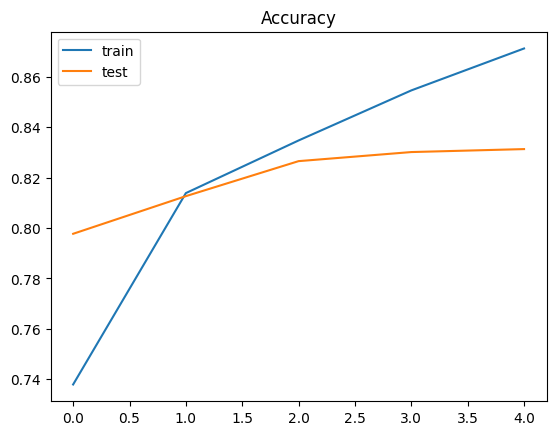

In [26]:
# accuracy evaluation
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

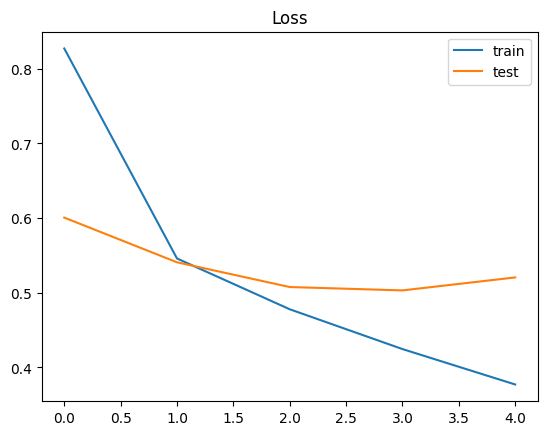

In [27]:
#loss evaluation
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [29]:
# test with a new complaint
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=256)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[4.5065000e-03 5.0810785e-03 3.3197537e-04 4.6898010e-01 4.3811161e-02
  4.7633684e-01 3.4908968e-04 2.5611595e-05 2.7753890e-04 7.8287296e-05
  1.4147095e-04 1.9148898e-05 6.1105537e-05]] Bank account or service
